In [1]:
%matplotlib inline
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from IPython.display import display 
from pathlib import Path
import pandas as pd

In [2]:
plt.rcParams["figure.figsize"] = (16,7)
sns.set_style("whitegrid")
pd.set_option("display.float_format", "{:.4f}".format)

## Training

In [3]:
class ModelSummary:
    
    def __init__(self, model_dir):
        self.model_dir = model_dir
        self.training_log = self.load_training()
        self.evaluation_log = self.load_evaluation()
        self.paths, self.uttids = self.load_evaluation_dump()
        
    def load_training(self):
        tags = ["o", "ok", "mono", "all"]
        results = pd.DataFrame()
        for tag in tags:
            jsonfile = Path(self.model_dir, "train", tag, "results", "log")
            if not jsonfile.exists():
    #             print(f"{jsonfile} not found")
                continue
            df = pd.read_json(jsonfile)
            df["dataset"] = tag
            results = pd.concat([results, df], axis=0)
    #         print(f"{tag}: {len(df)} results")

        return (
            results
            .assign(new_dataset=(results.index == 0))
            .reset_index(drop=True)
        )

    def training_summary(self, ax=None):
        training_log = self.training_log
        ax = ax or plt.subplot()
        training_log["main/loss"].plot(label="train loss (batch)", legend=False, ax=ax)
        epoch_mask = training_log["validation/main/loss"].notnull()

        (training_log.reset_index().groupby(["dataset", "epoch"], as_index=False)
         .agg({"main/loss": "mean", "index": "max"})
         .set_index("index").sort_index()
         .drop(["dataset", "epoch"], axis=1)
         .plot(ax=ax, label="train loss (epoch)", legend=False, alpha=.8))

        (training_log.loc[epoch_mask, "validation/main/loss"].dropna(how="any")
         .plot(ax=ax, label="val loss (epoch)", legend=False))

        ax.legend()
        for xi in training_log[training_log["new_dataset"]].index:
            ax.axvline(xi, color='gray')
            
    def load_evaluation(self):
        if not self.check_eval():
            print("Model was not evaluated?")
            return
        tags = list("abfghijklmno")
        results = pd.DataFrame()
        for tag in tags:
            jsonpath = Path(self.model_dir, "evaluate", tag, "results", "results.json")
            if not jsonpath.exists():
    #             print(f"{jsonpath} not found")
                continue

            with open(jsonpath, "rb") as jsonfile:
                data = json.load(jsonfile)["results"]
            df = pd.DataFrame.from_dict(data, orient="index")
            df["dataset"] = tag
            results = pd.concat([results, df], axis=0)
    #         print(f"{tag}: {len(df)} results")
        
        return results
    
    def display_metrics(self):
        display(self.evaluation_log.groupby("dataset")
                .agg({"accuracy": "mean", "wer": "mean", "loss": "mean"}))
    
    def evaluation_summary(self):
        if self.check_eval():
            self.display_metrics()
            self.plot_random_attention()
        
    def check_eval(self):
        return Path(self.model_dir, "evaluate").exists()
    
    def raise_on_no_eval(self):
        if not(self.check_eval):
            raise ValueError("Model was not evaluated?")

    def load_evaluation_dump(self):
        if not self.check_eval():
            print("Model was not evaluated?")
            return None, None
        
        paths = pd.DataFrame(
            list(Path(self.model_dir, "evaluate").glob("?/results/dump/*.npy")), 
            columns=["path"]
        )

        paths["comp"] = paths["path"].map(lambda p: p.parents[2].name)
        paths["type"] = paths["path"].map(lambda p: p.stem.split(".")[0])
        paths["batch_id"] = paths["path"].map(lambda p: p.stem.split(".")[1])
        paths = paths.set_index(["comp", "batch_id", "type"]).unstack(level=-1).droplevel(axis=1, level=0)

        uttids = pd.DataFrame((
            (uttid, comp, batch_id, sample_id) 
            for _, comp, batch_id, uttids in paths["uttids"].map(np.load).reset_index().itertuples() 
            for sample_id, uttid in enumerate(uttids)
        ), columns=["uttid", "comp", "batch_nr", "sample_id"]).set_index("uttid")
        
        return paths, uttids

    def plot_random_attention(self, uttid=None):
        self.raise_on_no_eval()
        sample = self.uttids.sample(1).iloc[0]
        attn = np.load(self.paths.loc[tuple(sample)[:2], "attn_ws"])[int(sample["sample_id"])]
        ax = sns.heatmap(attn, cmap='viridis')
        ax.set_title(f"{sample.name} (comp-{sample.comp})")
        
    def display(self):
        self.training_summary()
        self.evaluation_summary()

### vanilla

- started: 04/17 12:19:17
- config: conf/train_ep1000_es5.yaml
- batch size: 64
- epoch: 1000
- early stop: yes
- patience: 5
- sortagrad: 0
- preprocess: none

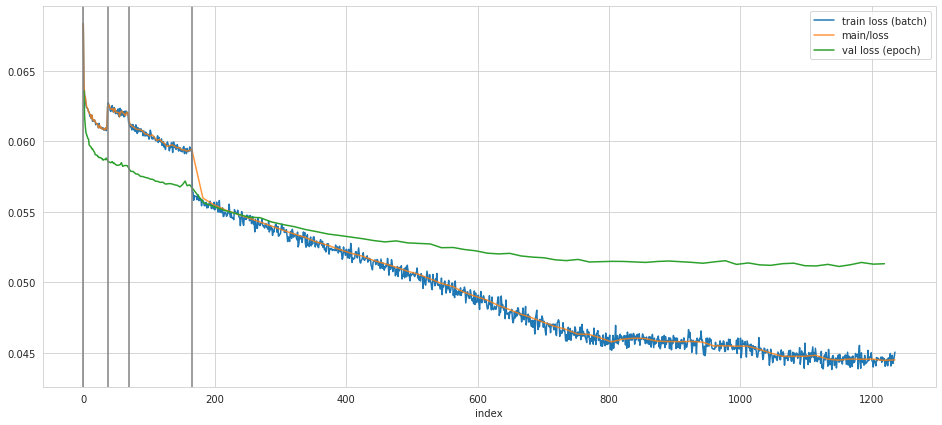

In [4]:
summary = ModelSummary("../exp/train_lstm_words_pretrained_curriculum/vanilla")
summary.training_summary()

,accuracy,wer,loss
dataset,,,
a,0.1044,0.8945,0.0502
b,0.1957,0.8008,0.0440
f,0.1578,0.8382,0.0491
g,0.1755,0.8229,0.0504
h,0.1603,0.8372,0.0508
i,0.1207,0.8770,0.0535
j,0.1941,0.8030,0.0501
k,0.1804,0.8172,0.0570
l,0.2116,0.7848,0.0520


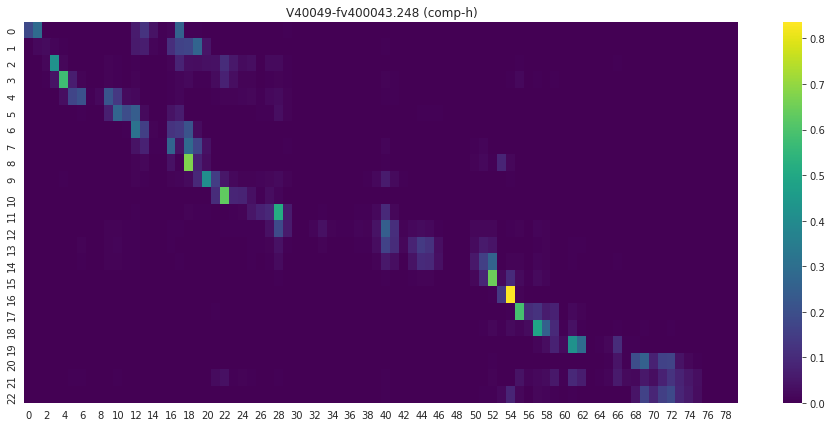

In [5]:
summary.evaluation_summary()

### fast

- started: 04/21 09:12:04
- config: conf/train_ep1000_es5_fast.yaml
- batch size: 256
- epoch: 1000
- early stop: yes
- patience: 5
- sortagrad: 0
- preprocess: none

Model was not evaluated?
Model was not evaluated?


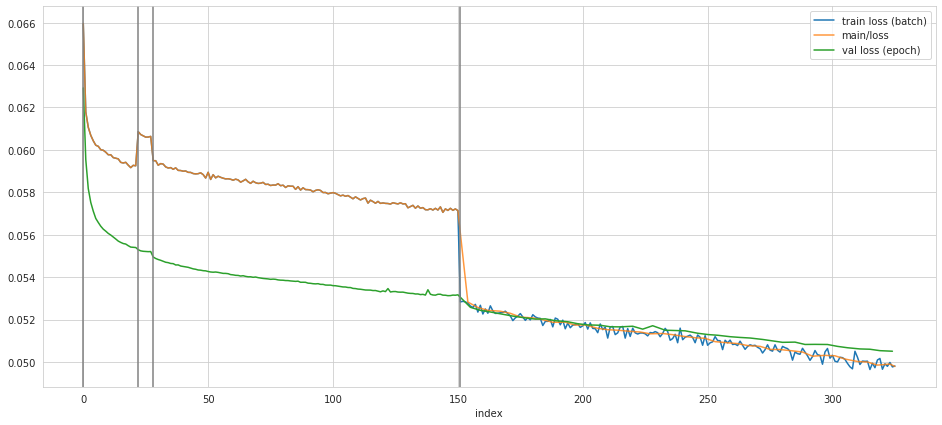

In [6]:
summary = ModelSummary("../exp/train_lstm_words_pretrained_curriculum/v2")
summary.training_summary()

### sorted

- started: 04/20 11:55:42
- config: conf/train_ep1000_es5_sorted.yaml
- batch size: 128
- epoch: 1000
- early stop: yes
- patience: 5
- sortagrad: -1
- preprocess: none

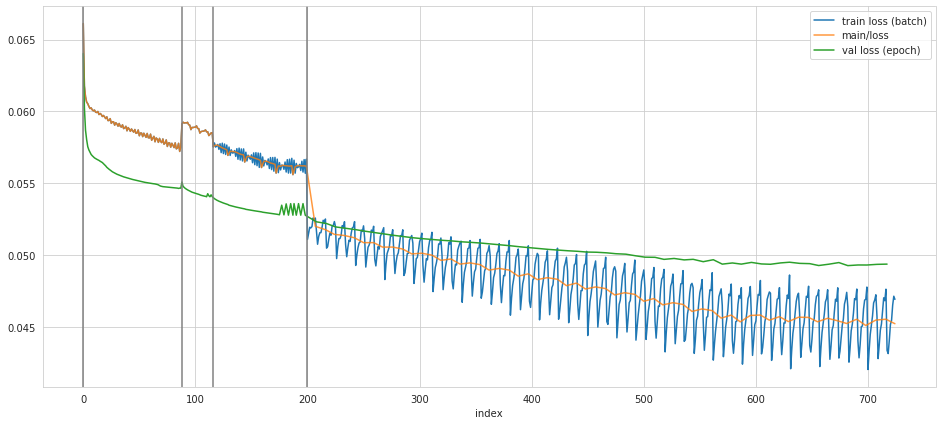

In [7]:
summary = ModelSummary("../exp/train_lstm_words_pretrained_curriculum/sorted")
summary.training_summary()

,accuracy,wer,loss
dataset,,,
a,0.0908,0.9084,0.0491
b,0.1555,0.8412,0.0440
f,0.1172,0.8803,0.0494
g,0.1262,0.8732,0.0517
h,0.1161,0.8819,0.0508
i,0.0814,0.9169,0.0541
j,0.1395,0.8583,0.0515
k,0.1376,0.8615,0.0584
l,0.1502,0.8477,0.0534


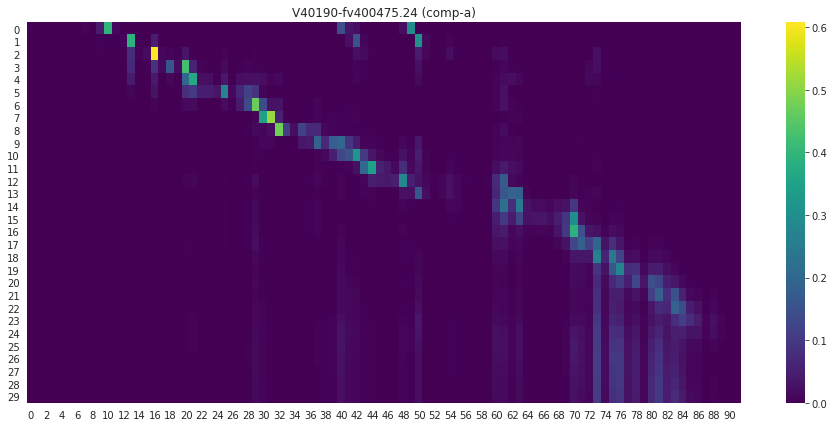

In [8]:
summary.evaluation_summary()

### SpecAugment

- started: 04/21 09:12:04
- config: conf/train_ep1000_es5_sorted.yaml
- batch size: 128
- epoch: 1000
- early stop: yes
- patience: 5
- sortagrad: 0
- preprocess: conf/specaug.yaml

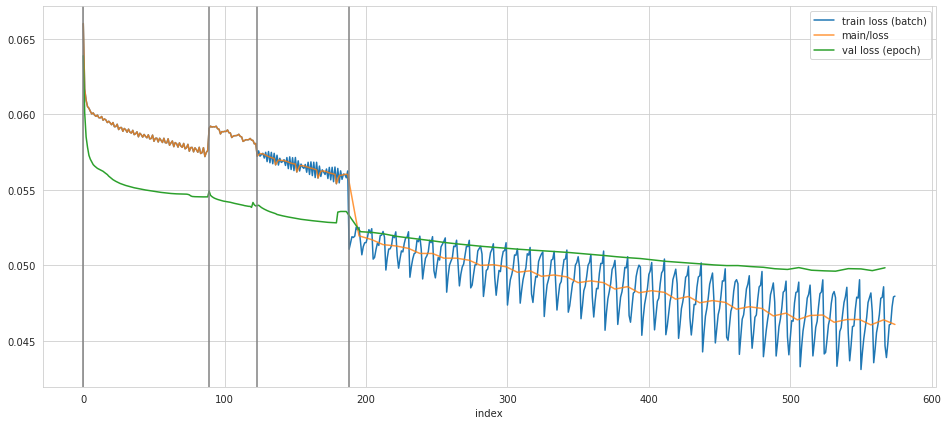

In [9]:
summary = ModelSummary("../exp/train_lstm_words_pretrained_curriculum/specaug")
summary.training_summary()

,accuracy,wer,loss
dataset,,,
a,0.0837,0.9155,0.0492
b,0.1464,0.8506,0.0443
f,0.1025,0.8949,0.0498
g,0.1165,0.8832,0.0520
h,0.1033,0.8951,0.0512
i,0.0737,0.9258,0.0545
j,0.1251,0.8729,0.0520
k,0.1242,0.8742,0.0589
l,0.1354,0.8627,0.0538


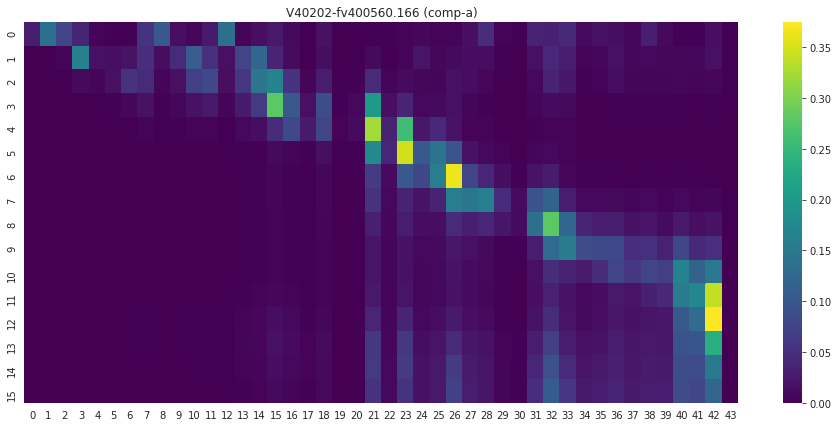

In [9]:
summary.evaluation_summary()

## Evaluation

In [186]:
def load_batch(batch_nr):
    result_dir = Path(model_dir, "evaluate", "results")
    output_files = list(result_dir.glob("*.npy"))
    
    attn_weights = np.load(list(filter(lambda p: p.stem == f"att_weights_batch{i}", output_files))[0])
    ids = np.load(list(filter(lambda p: p.stem == f"id_batch{i}", output_files))[0])
    targets = np.load(list(filter(lambda p: p.stem == f"target_batch{i}", output_files))[0])
    target_lengths = np.load(list(filter(lambda p: p.stem == f"target_lengths{i}", output_files))[0])
    preds = np.load(list(filter(lambda p: p.stem == f"predictions_batch{i}", output_files))[0])

    return {
        "attention": attn_weights,
        "uttids": ids,
        "targets": targets,
        "target_lengths": target_lengths,
        "predictions": preds
    }

def score(y_pred, y_true, ylen):
    return ((y_pred[:ylen] - y_true[:ylen]) ** 2).mean()

def batch_scores(batch):
    return np.array([score(
        batch["predictions"][i], 
        batch["targets"][i],
        batch["target_lengths"][i]
    ) for i in range(len(batch["predictions"]))])


In [1]:
# with open("../dump/CGN_test/deltafalse/data_words.all.json") as f:
#     test_set = json.load(f)["utts"]
    
# batch = load_batch(0)

In [2]:
# batch_scores(batch)

In [3]:
# batch["targets"][-1].shape, batch["predictions"][-1].shape

In [4]:
# i = -1
# sns.heatmap(batch["attention"][i][:batch["target_lengths"][i]], cmap="Blues");

In [190]:
def Embedding(num_embeddings, embedding_dim, eos_idx, eos_value=0):
    m = nn.Embedding(num_embeddings, embedding_dim)
    nn.init.uniform_(m.weight, -0.1, 0.1)
    nn.init.constant_(m.weight[eos_idx], eos_value)
    return m


def load_pretrained_embedding_from_file(embed_path, vocab, freeze=True, eos_idx=-1, eos_value=0):
    vocab = vocab.copy()
    num_embeddings = len(vocab)
    # eos_idx MUST be -1 (= the last one) otherwise, we will have a clash with the other indices
    # Note: can be easily solved in load_embedding, but does not matter a.t.m.
    assert eos_idx == -1 or eos_idx == num_embeddings - 1
    embed_dict = parse_embedding(embed_path)
    embed_dim = embed_dict[list(embed_dict)[0]].size(0)
    embed_tokens = Embedding(num_embeddings, embed_dim, eos_idx, eos_value)
    embed_tokens.weight.requires_grad = not freeze
    return load_embedding(embed_dict, vocab, embed_tokens)


def load_embedding(embed_dict, vocab, embedding):
    """[From fairseq]"""
    for idx in range(len(vocab)):
        token = vocab[idx]
        if token in embed_dict:
            embedding.weight.data[idx] = embed_dict[token]
    return embedding


def parse_embedding(embed_path):
    """[From fairseq] Parse embedding text file into a dictionary of word and embedding tensors.
    The first line can have vocabulary size and dimension. The following lines
    should contain word and embedding separated by spaces.
    Example:
        2 5
        the -0.0230 -0.0264  0.0287  0.0171  0.1403
        at -0.0395 -0.1286  0.0275  0.0254 -0.0932
    """
    embed_dict = {}
    with open(embed_path, encoding='utf-8') as f_embed:
        next(f_embed)  # skip header
        for line in f_embed:
            pieces = line.rstrip().split(" ")
            embed_dict[pieces[0]] = torch.Tensor(
                [float(weight) for weight in pieces[1:]]
            )
    return embed_dict

In [5]:
# with open(Path(model_dir, "train/all/results/model.json")) as jsonfile:
#     idim, odim, model_config = json.load(jsonfile)

# target_dict = model_config["char_list"]
    
# EMB_PATH = "/esat/spchdisk/scratch/qmeeus/repos/espnet/egs/cgn/asr1/data/lang_word/w2v_small.txt"
# embed_token = load_pretrained_embedding_from_file(
#     EMB_PATH, target_dict, freeze=True, eos_idx=-1
# )

# embed_token

In [206]:
import torch.nn.functional as F
from sklearn.neighbors import KNeighborsClassifier

def encode(tokens):
    vocab_size = 52165
    return F.one_hot(tokens, vocab_size)

emb_weights = 

tokens = torch.tensor([target_dict.index(w) for w in "ik ben blij".split()])
encoded = encode(tokens)
embedded = embed_token(tokens)

In [215]:
clf = KNeighborsClassifier(n_neighbors=1).fit(embed_token.weight, np.arange(len(target_dict)))

In [6]:
# sns.heatmap(target0_emb[0,:target_lengths[0]])

In [7]:
# sns.heatmap(torch.from_numpy(pred0[0,:target_lengths[0]]))

In [ ]:
targets = [np.load(p) for p in result_dir.glob("target_batch*.npy")]
predictions = [np.load(p) for p in result_dir.glob("predictions_batch*.npy")]